In [1]:
from fit.datamodules.tomo_rec.TRecDataModule import LoDoPaBFourierTargetDataModule
from fit.utils import convert2FC, fft_interpolate
from fit.utils.tomo_utils import get_proj_coords_pol, get_img_coords_pol, pol2cart

from fit.modules import TRecTransformerModule

from matplotlib import pyplot as plt

import torch

import numpy as np

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
seed_everything(22122020)

22122020

In [3]:
dm = LoDoPaBFourierTargetDataModule(batch_size=4, gt_shape=111, num_angles=33)
dm.setup()

In [4]:
det_len = dm.gt_ds.get_ray_trafo().geometry.detector.shape[0]

In [5]:
proj_r, proj_phi, src_flatten = get_proj_coords_pol(angles=dm.gt_ds.get_ray_trafo().geometry.angles, 
                                                          det_len=det_len)
target_r, target_phi, dst_flatten, order = get_img_coords_pol(img_shape=dm.gt_shape, det_len=det_len)

In [6]:
model = TRecTransformerModule(d_model=128, y_coords_proj=proj_r, x_coords_proj=proj_phi,
                             y_coords_img=target_r, x_coords_img=target_phi, 
                             src_flatten_coords=src_flatten, dst_flatten_coords=dst_flatten, 
                             dst_order=order,
                             angles=dm.gt_ds.get_ray_trafo().geometry.angles, img_shape=dm.gt_shape,
                             detector_len=det_len,
                             loss='prod', use_fbp=True,
                             init_bin_factor=2, bin_factor_cd=5,
                             lr=0.0001, weight_decay=0.01, attention_type='linear', n_layers=4,
                             n_heads=8, d_query=128//8, dropout=0.1, attention_dropout=0.1)

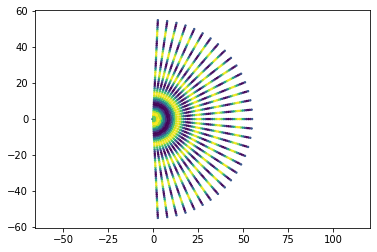

In [7]:
plt.scatter(*pol2cart(proj_r[src_flatten], proj_phi[src_flatten]), c=model.trec.pos_embedding_input_projections.pe[0,:,2],
           marker='.', s=8)
plt.axis('equal');

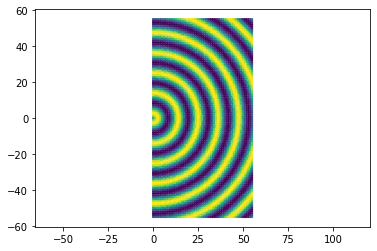

In [8]:
plt.scatter(*pol2cart(target_r[dst_flatten], target_phi[dst_flatten]), c=model.trec.pos_embedding_target.pe[0,:,2],
           marker='.', s=8)
plt.axis('equal');

In [9]:
trainer = Trainer(max_epochs=20, 
                  gpus=1,
                  checkpoint_callback=ModelCheckpoint(
                                            filepath=None,
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Train/avg_val_mse',
                                            mode='min',
                                            prefix='best_val_loss_'
                                        ), 
                  deterministic=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [10]:
trainer.fit(model, datamodule=dm);


  | Name | Type            | Params
-----------------------------------------
0 | trec | TRecTransformer | 1.9 M 
-----------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
/home/tbuchhol/Programs/miniconda3/envs/ft/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/tbuchhol/.local/lib/python3.7/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/tbuchhol/Programs/miniconda3/envs/ft/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/tbuchhol/Gitrepos/FourierImageTransformer/fit/utils/RAdam.py:119: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Saving latest checkpoint...
